# Aster Analysis Pipeline

Here I work to really clean up the aster analysis process and make it very automated for easy processing of many datasets. 

# Imports

Package imports:

In [1]:
#for reading files
import glob

#math computation and data organization
import numpy as np
import scipy
import pandas as pd

# For loading bars
from tqdm.notebook import tqdm as tqdm

#For image plotting
import skimage.io

#For identifying aster center
from skimage.filters import threshold_otsu, gaussian, threshold_mean
from skimage.measure import regionprops
import cv2

#for fitting
from lmfit import minimize, Parameters, fit_report

#for image registration
from skimage.registration import phase_cross_correlation
import os

#Matplotlib plotting packages
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import patches
from matplotlib import gridspec

#Movie
import celluloid as cell
import matplotlib.animation as animation

#for saving data
import csv

#custom analysis packages
import aster_packages as ap

Figure design based on rp package

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[ ]:

# Figure Formatting
import matplotlib.pyplot as plt
import matplotlib as mpl

figwidth = 4
plt.rcParams["figure.figsize"] = [figwidth, figwidth * 1105 / 1920
                                  ]  # figure size in inches
plt.rcParams["lines.linewidth"] = 2  # line width in points
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times"

plt.rcParams["font.style"] = "normal"
plt.rcParams["font.weight"] = "heavy" #chick this later maybe the source of weirdness in labels (ANA READ THIS)
plt.rcParams["font.size"] = 13.0
plt.rcParams["axes.labelweight"] = "bold"  # weight of the x and y labels
plt.rcParams["axes.spines.right"] = True
plt.rcParams[
    "axes.formatter.useoffset"] = True  # If True, the tick label formatter
plt.rcParams["xtick.major.size"] = 10  # major tick size in points
plt.rcParams["xtick.minor.size"] = 4  # minor tick size in points
plt.rcParams["xtick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["xtick.minor.visible"] = True
plt.rcParams["ytick.major.size"] = 10  # major tick size in points
plt.rcParams["ytick.minor.size"] = 4  # minor tick size in points
plt.rcParams["ytick.direction"] = "in"  # direction in, out, or inout
plt.rcParams["ytick.minor.visible"] = True
plt.rcParams["legend.fontsize"] = 10
plt.rcParams[
    "legend.labelspacing"] = 0.1  # the vertical space between the legend entries in fraction of fontsize
plt.rcParams["legend.shadow"] = False
plt.rcParams[
    "legend.frameon"] = True  # whether or not to draw a frame around legend
plt.rcParams[
    'axes.unicode_minus'] = False  # fix glyph error by using normal hyphens
plt.rcParams.update({"text.usetex": True, 
             "font.family": "Times"})
mpl.rc("figure", dpi=200)

color_background = '#E5E0D5'

## Specify data locations

Parameter Settings:

In [3]:
#Length Calibration (microns to pixels)
um_per_pixel = 0.59/2 #microscope thought that the magnification was 5x when it was actually 10x meaning there are fewer um for the same amount of pixels

#Image dims
w_px, h_px = 1920, 1200  #pixels
w_um, h_um = w_px * um_per_pixel, h_px * um_per_pixel  # microns

#min area thresh (IN PIXELS)
area_thresh = 1000

#Fontsize
f_small, f_big = 13, 15

#For binning
winsize = 200
winsize_um = 200 * um_per_pixel
print('winsize: '+str(winsize_um)+' µm (the half width of the final crop)')
thickness = 20
scale = 5

#motor concentration
init_mot = 0.6 #uM (NCD dimers)

# #Total number of imported images per channel
# total_frames = len(im_arraymot) - 1

winsize: 59.0 µm (the half width of the final crop)


Aster Data:

In [4]:
#Choose the experiment file name(located in folder 'Asters'):
file_path = '../../data/aster/'
file_folder = '2023-12-12_NCD_Aster/20sInterval_0.6uM_NCD_dimers_500uMATP_1.3uM_tubulin_2.8uM_A81D_2/'

# #Choose the position(s)/aster(s) of interest:
pos_list = ['Pos1']

#Choose the channels of interest (Write in the order of bound, unbound, motor, mt)
channel_list = ['405', '480', 'Cherry']
channel_id = ['bnd', 'unbnd', 'mot']

#included frames
included_frames = '*ome*.tif'


Dark image or made up dark image:

In [5]:
im_dark = 1915*np.ones((h_px, w_px))
im_bnd_dark = im_dark
im_unbnd_dark = im_dark
im_mot_dark = im_dark

ATP Calibration:

In [6]:
#Choose the experiment file name(located in folder 'atp_cal'):
cal_file_path = '../../analyzed_data/atp_cal/'
cal_file_folder = '2023-12-16_A81D_Cal/'
cal_file_name = 'df_fit'

#read the DataFrame
atp_cal_fit = pd.read_csv(cal_file_path+cal_file_folder+cal_file_name)

#Define constants
Km, Rmax, Rmin, nhill = atp_cal_fit['Value']

#Print DataFrame
atp_cal_fit

,Unnamed: 0,Param,Value
0,0,Km,66.328007
1,1,Rmax,3.628741
2,2,Rmin,1.106981
3,3,n,1.351722


## Start

In [7]:
# Import images
for pos in pos_list:
    for i, channel in enumerate(channel_list):

        #creates an empty list with the naming convention
        exec('im_files' + channel + pos + '= []')
        im_files = eval('im_files' + channel + pos)
        
        #appends all the file names
        im_files.append(
            np.sort(
                glob.glob(file_path + file_folder + pos + '/' + channel + '/' + included_frames)))

        #Reads the files as images
        exec('im_array' + channel_id[i] + ' = ap.file_to_image(im_files[0])')
        print('im_array' + channel_id[i])

im_arraybnd
im_arrayunbnd
im_arraymot


## Subtract the camera background image
Subtract the dark camera image from each image and the autofluorescent image. If there are any negative values, set them to zero

In [8]:
# subtracting bg image
im_arraybnd_bs = im_arraybnd - im_bnd_dark
im_arrayunbnd_bs = im_arrayunbnd - im_unbnd_dark
im_arraymot_bs = im_arraymot - im_mot_dark

# Set negative values to zero
bool_array = (im_arraybnd_bs > 0)
im_arraybnd_bs_nonneg = im_arraybnd_bs * bool_array

bool_array = (im_arrayunbnd_bs > 0)
im_arrayunbnd_bs_nonneg = im_arrayunbnd_bs * bool_array

bool_array = (im_arraymot_bs > 0)
im_arraymot_bs_nonneg = im_arraymot_bs * bool_array

## Normalize Images
This corrects for uneven illumination. The light gradient that comes from instrumentation "should" be the same for each frame. Here, take the first frame of the image sequence and create a normalization matrix. This matrix is created by dividing each pixel in the image by the maximum pixel value, so that when you multiply the original image by the normalization matrix, the first frame will be a homogeneous image with the highest pixel value. All future frames can be multiplied by the matrix to remove the systematic light gradient

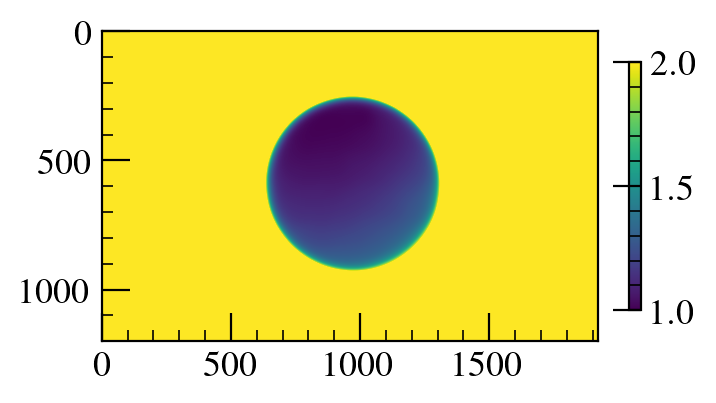

In [9]:
#Set the first image as the sacrificial normalization image
bnd_zero = im_arraybnd[0]
unbnd_zero = im_arrayunbnd[0]
mot_zero = im_arraymot[0]

# Create the normalization matrix
bnd_norm_mat = ap.norm_mat_fn_iATP(bnd_zero, im_bnd_dark)
unbnd_norm_mat = ap.norm_mat_fn_iATP(unbnd_zero, im_unbnd_dark)
mot_norm_mat = ap.norm_mat_fn_iATP(mot_zero, im_mot_dark)

#Plot the normalization matrix
plt.imshow(bnd_norm_mat, vmin = 1, vmax = 2)
plt.colorbar(shrink = 0.7)

Multiply the image stacks by a binary image and then the normalization matrix:

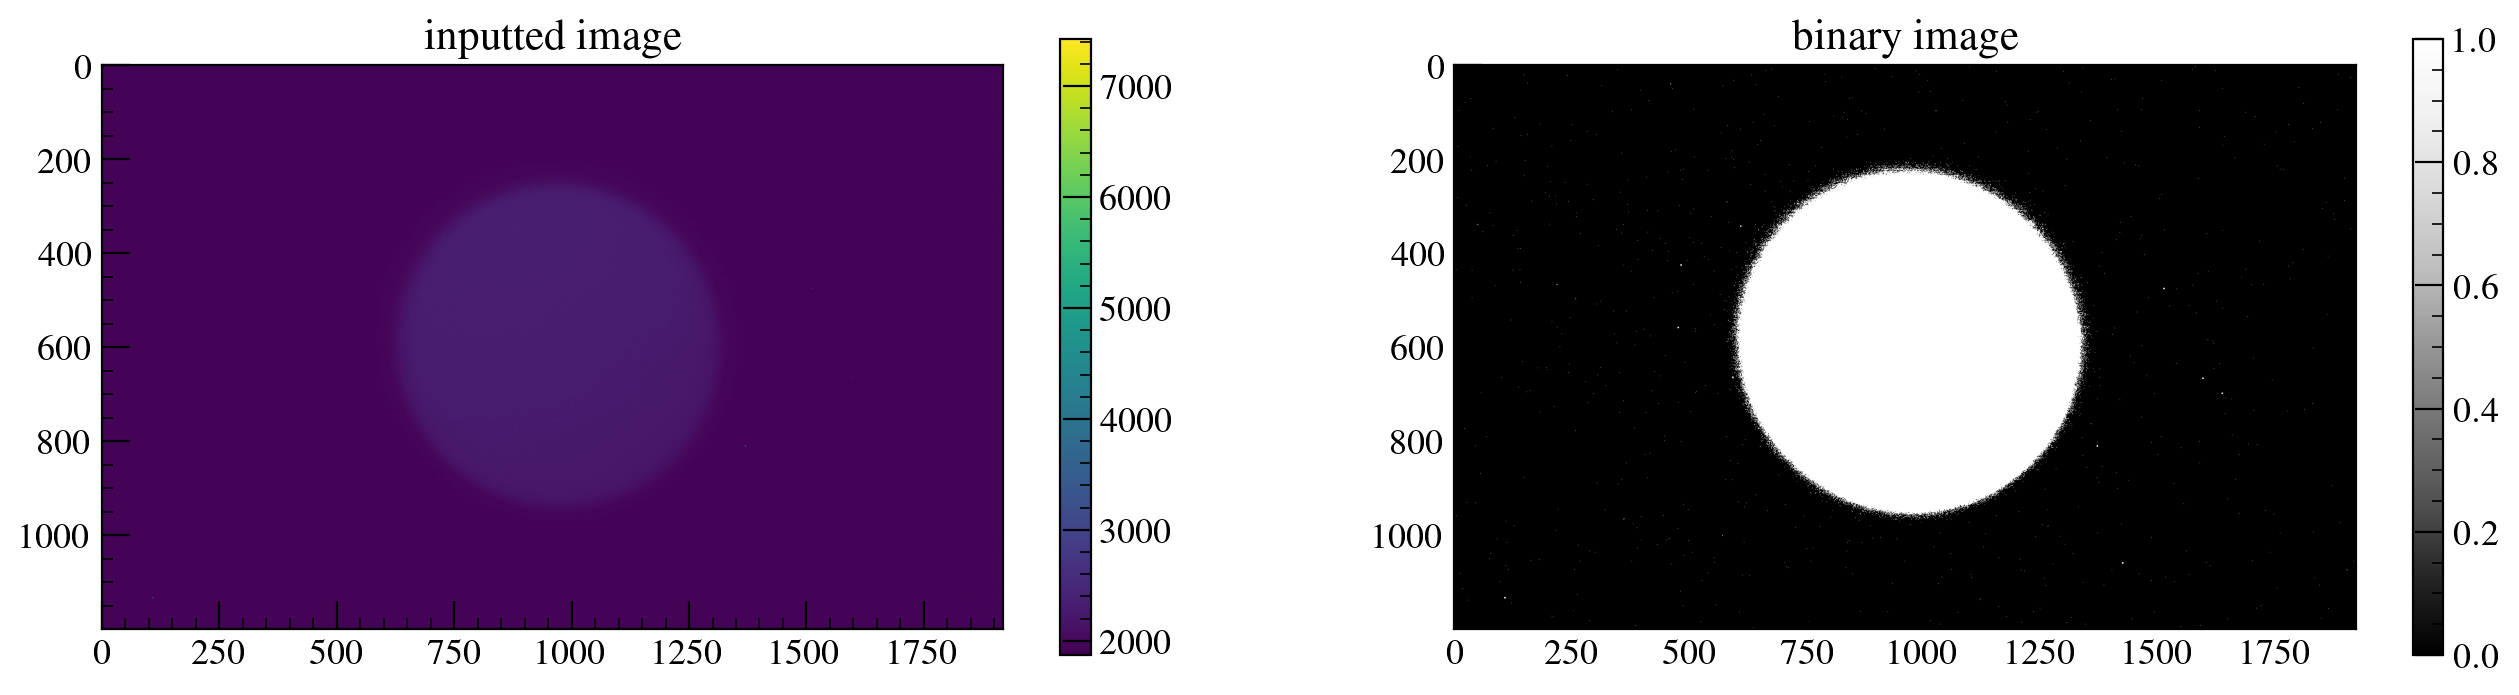

In [10]:
#Ensure all pixels are floats
im_arraybnd_bs_nonneg = im_arraybnd_bs_nonneg.astype(float)
im_arrayunbnd_bs_nonneg = im_arrayunbnd_bs_nonneg.astype(float)
im_arraymot_bs_nonneg = im_arraymot_bs_nonneg.astype(float)

#Multiply by a binary mask that only retains non-zero values for inside the roi
im_binary = ap.binary_im_generator(bnd_zero)
bnd_norm_mask = bnd_norm_mat * im_binary
unbnd_norm_mask = unbnd_norm_mat * im_binary

# Multiply the images by the normalization matrix
im_arraybnd_bs_norm = bnd_norm_mask * im_arraybnd_bs_nonneg
im_arrayunbnd_bs_norm = unbnd_norm_mask * im_arrayunbnd_bs_nonneg
im_arraymot_bs_norm = mot_norm_mat*im_arraymot_bs_nonneg


## Photobleaching correction
this is only applyed to the motor channel. The basis of this is to take the edges of the image outside the light activated region where motor concentration should not change and look at the intensity change over time. ATP channels don't have data in the far field outside the circle

0it [00:00, ?it/s]

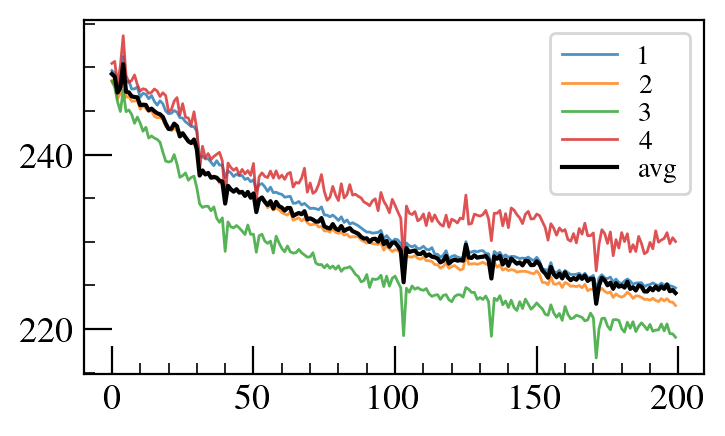

In [11]:
avg1 = np.zeros(len(im_arraymot_bs_norm))
avg2 = np.zeros(len(im_arraymot_bs_norm))
avg3 = np.zeros(len(im_arraymot_bs_norm))
avg4 = np.zeros(len(im_arraymot_bs_norm))
edgemotavg = np.zeros(len(im_arraymot_bs_norm))

for i, im in tqdm(enumerate(im_arraymot_bs_norm)):
    avg1[i] += np.average(im[:, 100:300])
    avg2[i] += np.average(im[:, -300:-100])
    avg3[i] += np.average(im[50:150, :])
    avg4[i] += np.average(im[-150:-50, :])
    edgemotavg[i] += np.average([avg1[i], avg2[i], avg3[i], avg4[i]])

#Plotting
plt.plot(np.arange(len(edgemotavg)), avg1, label = '1', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgemotavg)), avg2, label = '2', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgemotavg)), avg3, label = '3', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgemotavg)), avg4, label = '4', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgemotavg)), edgemotavg, label = 'avg', color = 'k', linewidth=1.5)
plt.legend();

Find the bleaching correction and mutiply all images by the correction

In [12]:
bleach_correction = edgemotavg[0]/edgemotavg
bleach_correction_ims = np.ones((len(bleach_correction), h_px, w_px))
for i, im in enumerate(tqdm(bleach_correction_ims)):
    bleach_correction_ims[i] *= im*bleach_correction[i] 
im_arraymot_bs_norm_bleach = im_arraymot_bs_norm*bleach_correction_ims

  0%|          | 0/200 [00:00<?, ?it/s]

Look at correction

  0%|          | 0/200 [00:00<?, ?it/s]

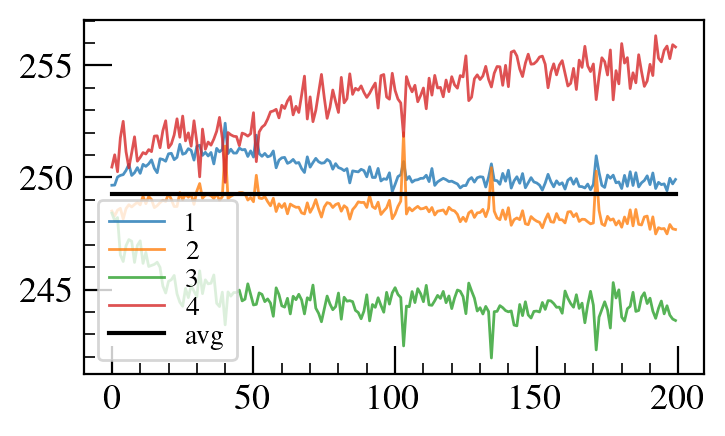

In [13]:
avg5 = np.zeros(len(im_arraymot_bs_norm))
avg6 = np.zeros(len(im_arraymot_bs_norm))
avg7 = np.zeros(len(im_arraymot_bs_norm))
avg8 = np.zeros(len(im_arraymot_bs_norm))
edgemotavg1 = np.zeros(len(im_arraymot_bs_norm))

for i, im in enumerate(tqdm(im_arraymot_bs_norm_bleach)):
    avg5[i] += np.average(im[:, 100:300])
    avg6[i] += np.average(im[:, -300:-100])
    avg7[i] += np.average(im[50:150, :])
    avg8[i] += np.average(im[-150:-50, :])
    edgemotavg1[i] += np.average([avg5[i], avg6[i], avg7[i], avg8[i]])


plt.plot(np.arange(len(edgemotavg)), avg5, label = '1', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgemotavg)), avg6, label = '2', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgemotavg)), avg7, label = '3', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgemotavg)), avg8, label = '4', alpha=0.8, linewidth=1)
plt.plot(np.arange(len(edgemotavg)), edgemotavg1, label = 'avg', color = 'k', linewidth=1.5)
plt.legend();


## Center Identification 
Define a crop window

In [14]:
#currently no crop
c_ymin, c_ymax, c_xmin, c_xmax = 0, -1, 0, -1
crop = np.s_[c_ymin:c_ymax, c_xmin:c_xmax]

Find what the center values are for all the images by taking a gaussian blur, finding the contour of the center above a threshold, enclosing the threshold in a circle and take the center. Note I do not consider the center for the first 11 frames since it is hard to define boundaries, the code will print "center not found" for the first 11 frames which is ok.

In [15]:
#init empty lists for center vals, radius, frame #
centers_tc = []
radii = []
frame_num = []
contours_plot = []

#for loop thru MT images
for i, im in enumerate(tqdm(im_arraymot_bs_norm)):
   
    #gaussian blur
    dst = gaussian(im[crop], sigma=50)
    
    #Create a binary mask for above a threshold
    thresh = threshold_otsu(dst) #Otsu threshold method
#     thresh = np.percentile(dst, 98.5) #Percentile threshold method
    binary = (dst>thresh).astype(np.uint8)
    
    #create a contour
    contours, hierarchy = cv2.findContours(binary, 1, 2)

    #iterate through contours (for most connected region)
    max_area = 0
    max_index = None

    #Find the contour that encomppasses the largest area, this will be 
    #the best center circle guess
    for j, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_index = j

    #Conditional to find the center - only look if the contour is bigger
    #than a threshold radius defined above
    if (max_area >= area_thresh and i > 10):
        cnt = contours[max_index]
        #Find a circle that best encloses the contour
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        #save the center, radii, and frame number
        centers_tc.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
        frame_num.append(i)
        
        #fromat the contour indices for plotting
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)
    
    #If the contour is not well defined for the image, abort
    else:
        print("**CENTER NOT FOUND** - Frame " + str(i))
        cnt = contours[max_index]
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        centers_tc.append([x + c_xmin, y + c_ymin])
        radii.append(radius)
#         frame_num.append(i)
        
        cnt = np.array(cnt)
        cnt = np.squeeze(cnt)
        cnt[:,0] += c_xmin
        cnt[:,1] += c_ymin
        contours_plot.append(cnt)

#Convert lists to arrays
centers_tc = np.array(centers_tc)
radii = np.array(radii)
radii_um = radii*um_per_pixel
frame_num = np.array(frame_num)

  0%|          | 0/200 [00:00<?, ?it/s]

**CENTER NOT FOUND** - Frame 0
**CENTER NOT FOUND** - Frame 1
**CENTER NOT FOUND** - Frame 2
**CENTER NOT FOUND** - Frame 3
**CENTER NOT FOUND** - Frame 4
**CENTER NOT FOUND** - Frame 5
**CENTER NOT FOUND** - Frame 6
**CENTER NOT FOUND** - Frame 7
**CENTER NOT FOUND** - Frame 8
**CENTER NOT FOUND** - Frame 9
**CENTER NOT FOUND** - Frame 10


If the images were cropped when definining the center, convert the centers back to full image coordinates

In [16]:
centers = []
for center in centers_tc:
    center_x = int(center[0])
    center_y = int(center[1])
    centers.append([center_x, center_y])
centers = np.array(centers)

As a test, plot the centers

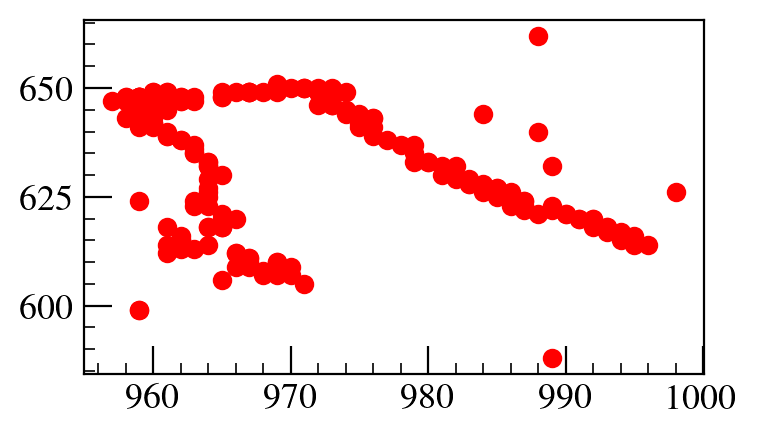

In [17]:
plt.figure()

for i in range(np.shape(centers)[0]):
    plt.scatter(centers[i, 0], centers[i, 1], color='r')

  0%|          | 0/189 [00:00<?, ?it/s]

0it [00:00, ?it/s]

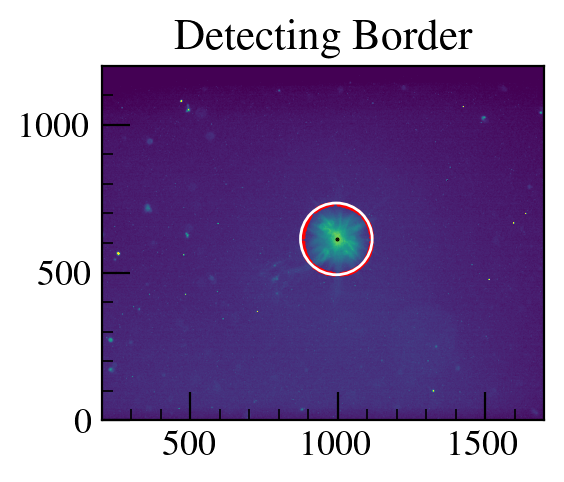

In [73]:
#TEST: checking ALL FRAMES centers (VERY slow)
ims = []
cmap = cm.get_cmap('Greys_r')
normalizer = Normalize(np.percentile(im_arraymot_bs,10), np.percentile(im_arraymot_bs,99.99))
cb_setting = cm.ScalarMappable(norm=normalizer)
fig, ax = plt.subplots()

ax.set_xlim([200, 1700])
ax.set_ylim([0, 1200])
ax.set_title("Detecting Border")

camera = cell.Camera(fig)

for i in tqdm(frame_num):
    im_temp = im_arraymot_bs[i]
    im = ax.imshow(im_temp,
                   vmin=np.percentile(im_temp, 10),
                   vmax=np.percentile(im_temp, 99.99),
                   animated=True,
                   zorder=0)

    ax.scatter(contours_plot[i][:, 0],
               contours_plot[i][:, 1],
               color='r',
               s=0.2)
    ax.scatter(centers_tc[i, 0], centers_tc[i, 1], color='black', s=0.2)

    circle1 = plt.Circle((centers[i, 0], centers[i, 1]),
                         radii[i],
                         fill=False,
                         color='w')
    ax.add_patch(circle1)
    camera.snap()

animation = camera.animate()
tqdm(animation.save("../../analyzed_data/aster/testmovie_pos1_12-12-23_NCD0.6uM_aster.mp4"))

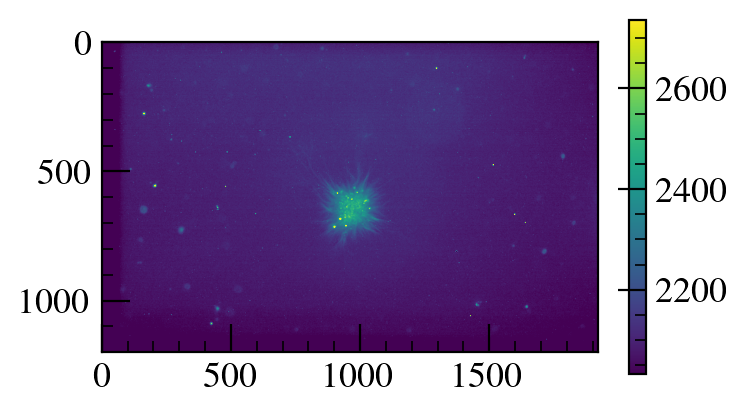

In [70]:
plt.imshow(im_arraymot[100], vmin=np.percentile(im_arraymot,10), vmax=np.percentile(im_arraymot,99.99))
plt.colorbar()

## Define Time arrray

In [18]:
#Define a cut off for the calibration curve data
times = frame_num * 20 / 60  #min
included = np.s_[:]

#Define the frames to plot
plot_frames = frame_num[included]
plot_times = times[included] #min

## Register Images
The different channels may not perfectly overlap. Here ensure the centers correctly overlap for all channels


In [19]:
#Empty list to record how much unbnd (probe) channel is shifted w.r.t. bnd (ATP is bound) channel
shifts = []

for i in range(len(im_arraybnd_bs_norm)):
    shift, error, _ = phase_cross_correlation(
        im_arraybnd_bs_norm[i][crop], im_arrayunbnd_bs_norm[i][crop])
    shifts.append(shift)

shifts = np.array(shifts)

## Create plotting arrays - create ratio images and motor images for plot

  0%|          | 0/189 [00:00<?, ?it/s]

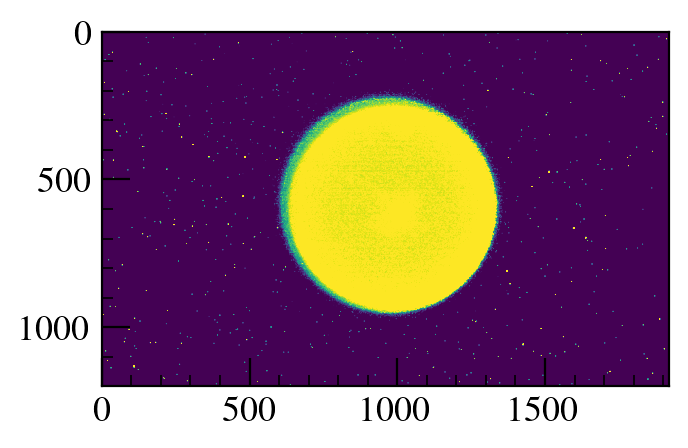

In [20]:
#cropped aster images
im_arraybnd_plot = []
im_arrayunbnd_plot = []
im_arraymot_plot = []

ratios_plot = []

#Traces for asters
trace_pts_bnd = []
trace_pts_unbnd = []
mot_trace_pts = []

ratios_trace_pts = []

for i in tqdm(frame_num):
    i_min = int(centers[i][0] - winsize)
    i_max = int(centers[i][0] + winsize)
    j_min = int(centers[i][1] - winsize)
    j_max = int(centers[i][1] + winsize)

    #demi-variable for shift
#     shift_j = int(shifts[i][0])
#     shift_i = int(shifts[i][1])

    shift_j = 0
    shift_i = 0
    
    #set _bnd and _unbnd windows
    win_bnd = np.s_[j_min:j_max, i_min:i_max]
    win_unbnd = np.s_[(j_min - shift_j):(j_max - shift_j),
                   (i_min - shift_i):(i_max - shift_i)]
    win_mot = np.s_[j_min:j_max, i_min:i_max]
    im_temp = im_arraybnd_bs_norm[i]
    plt.imshow(im_temp, vmin=0, vmax=np.percentile(im_temp, 90))
    
    #Append the plotting images
    [h, w] = np.shape(im_arraybnd_bs_norm[i])
    
    im_arraybnd_plot.append(im_arraybnd_bs_norm[i][win_bnd])
    im_arrayunbnd_plot.append(im_arrayunbnd_bs_norm[i][win_unbnd])
    im_arraymot_plot.append(im_arraymot_bs_norm_bleach[i][win_mot]) #CHANGED TO BLEACH HERE
    #for now MT same as _unbnd shifts, running the shift cell seems closest to _unbnd

    ratio = im_arraybnd_bs_norm[i][win_bnd] / im_arrayunbnd_bs_norm[i][win_unbnd]
    ratios_plot.append(ratio)

im_arraybnd_plot = np.array(im_arraybnd_plot)
im_arrayunbnd_plot = np.array(im_arrayunbnd_plot)
ratios_plot = np.array(ratios_plot)

pos_xaxis = np.linspace(-winsize, winsize, 2 * winsize)

## Convert to concentration units

In [21]:
def ATP_inten_to_conc(array, Km, Rmax, Rmin, nhill):
    return Km * ((Rmin - array) / (array - Rmax)) ** (1/nhill)

In [22]:
def calibrate_motor(mot_output, protein_per_fluo):
    """
    Calibrate a fluorescence image using the normalization matrix and
    the intensity calibration factor.
    
    Parameters
    ----------
    im : numpy array
        Image to be calibrated.
    
    norm_mat : numpy array
        Normalization matrix.
        
    offset_camera : float
        Camera offset (not accounting for autofluorescence).
        
    auto_fluo : float
        Autofluorescence (coming from the energy mix).
        
    protein_per_fluo : float
        Calibration factor for converting fluorescence units
        into protein concentration units.
        
    Returns
    -------
    im : numpy array
        Calibrated image.
    """
    
    mot_output = mot_output * protein_per_fluo
    return mot_output

## Find motor calibration
find the amount of motors per fluorescence by taking the homogenous first frame to be the known amount of pipetted motors. Assume fluorescence scales linearly

In [23]:
protein_per_fluo = init_mot/np.average(im_arraymot_bs_norm_bleach[0]) #µM

Define motor images in concentration units

In [24]:
### Define the motor data to work with and convert to concentration
ims_mot = im_arraymot_plot[included]
ims_mot_conc = []
for im in tqdm(ims_mot):
    im_conc = calibrate_motor(im, protein_per_fluo)
    ims_mot_conc.append(im_conc)

  0%|          | 0/189 [00:00<?, ?it/s]

Define ratio images in concentration units, set all nans to zero

In [25]:
### Define the ratio data to work with and convert to concentration
ims_ratio = ratios_plot[included]
ims_ratio_conc = []

#convert each image to concentration values
for im in tqdm(ims_ratio):
    #set nans to zero
    im_conc = np.nan_to_num(ATP_inten_to_conc(im, Km,  Rmax,   Rmin,  nhill))
    ims_ratio_conc.append(im_conc)
#format as a np.array
ims_ratio_conc = np.array(ims_ratio_conc)

  0%|          | 0/189 [00:00<?, ?it/s]

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_18955/907947138.py:2: RuntimeWarning: invalid value encountered in power
  return Km * ((Rmin - array) / (array - Rmax)) ** (1/nhill)


save ATP image data as numpy arrays for future processing - define a function to convert 3D arrays into a CSV file

In [26]:
def numpy_array_to_csv(array, csv_filename):
    # Reshape the 3D array into a 2D array
    flattened_array = array.reshape(-1, array.shape[-1])

    # Write the data to a CSV file
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in flattened_array:
            writer.writerow(row)

Save the ratio data

In [44]:
# Convert the numpy array to a CSV file
numpy_array_to_csv(ims_ratio_conc, file_path+file_folder+'ratioim_concunits.csv')


Code for reading saved data back as a 3D Numpy array

In [27]:
def csv_to_numpy_array(csv_filename, original_shape):
    # Read the data from the CSV file
    data = []
    with open(csv_filename, 'r') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            data.append([float(val) for val in row])

    # Convert the data to a numpy array and reshape it to the original shape
    array = np.array(data)
    array = array.reshape(original_shape)

    return array

Load the csv

In [45]:
# Convert the CSV file back to a numpy array
reconstructed_array = csv_to_numpy_array(file_path+file_folder+'ratioim_concunits.csv', np.shape(ims_ratio_conc))

Check if the new loaded data is the same as the saved data

In [46]:
np.where(reconstructed_array!=ims_ratio_conc)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

Save time data

In [47]:
np.savetxt(file_path+'/'+file_folder+'/plot_times_min.csv', plot_times, delimiter=',')

# Radial Trace analysis

## Profile Functions

In [28]:
def profile_fn(im,
               r_min=2.5,
               dr=1.5,
               r_max=None,
               avg_method='median',
               n_positions=100,
               n_wedge=16):
    """
    Calculate the radial intensity profile of an image, 
    assuming that the (0,0) coordinate is at the center of the image.
    
    Parameters
    ----------
    im : numpy array
        The cropped image of the aster (grayscale).
      
    r_min : float
        Minimum radius beyond which the intensity profile is calculated [px].
    
    dr : float
        Radial binning size [px].
    
    avg_method : string
        The method used for doing a radial average of intensities.
        'median' - median averaging
        'mean' - mean averaging
        
    n_positions : integer
        Number of uniformly spaced radial positions where the average
        intensity is calculated.
        
    n_wedge : integer
        Number of angular bins
        
                      
    Returns
    -------
    profile_output : dictionary
        Dictionary of different outputs listed below
    
      r_unif_ls : numpy array
          Uniformly spaced radii where the average intensity is evaluated.
          
      avg_ls : numpy array
          Average intensities evaluated at 'n_positions' different uniformly
          spaced radii.
          
      std_ls : numpy array
          Standard deviations of intensity values in differents wedges
          
      avg_bin_mat : numpy array
          Two dimensional array to store the average fluorescence values
          at each of 'n_positions' radii and for each angular bin
          
      angles : numpy array
          List of average angles at different bins. E.g., if the upper and
          lower θ-limits are (30° and 60°), then the corresponding element
          in angles will be 45°.
          
      r_ls : numpy array
          Radial distances of all image pixels from the image center.
          
      im_ls : numpy array
          All pixel intensities in the same order as 'r_ls'.
    """

    # Ensure that the image is a numpy array
    if not isinstance(im, np.ndarray):
        im = np.array(im)

    # Dimensions of the image
    H, W = im.shape

    # Array of the radial distance of each point from the center
    x_mat, y_mat = np.meshgrid(np.arange(W), np.arange(H))
    x_center = 0.5 * W - 0.5
    y_center = 0.5 * H - 0.5
    r_mat = np.sqrt((x_mat - x_center)**2 + (y_mat - y_center)**2)
    angle_mat = np.mod(np.arctan2(y_mat - y_center, x_mat - x_center),
                       2 * np.pi)

    # Convert 2d arrays into 1d arrays
    r_ls = r_mat.flatten()
    im_ls = im.flatten()
    angle_ls = angle_mat.flatten()

    # Uniformly spaced radii, starting with r_min and
    # ending with the smallest dimension of the image halved,
    # if r_max is not explicitly specified
#     if type(r_max) != np.ndarray:
#         r_max = 0.5 * np.min([H, W]) - 0.5

    r_unif_ls = np.linspace(r_min, r_max, n_positions)

    # List of bin angles
    angle_bins = np.radians(np.linspace(0, 360, n_wedge + 1))
    angles = 0.5 * (angle_bins[1:] + angle_bins[0:-1])

    # Matrix to store average profiles in each radial bin
    avg_bin_mat = [[] for _ in range(n_wedge)]

    for i, r in enumerate(r_unif_ls):
        dat = im_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]
        angle_disk = angle_ls[(r_ls > r - 0.5 * dr) & (r_ls < r + 0.5 * dr)]

        for k in range(n_wedge):
            dat_bin = dat[(angle_disk > angle_bins[k])
                          & (angle_disk <= angle_bins[k + 1])]

            if avg_method == 'median':
                avg_dat_bin = np.median(dat_bin)
            elif avg_method == 'mean':
                avg_dat_bin = np.mean(dat_bin)
            avg_bin_mat[k].append(avg_dat_bin)

    avg_bin_mat = np.array(avg_bin_mat)
    if avg_method == 'median':
        avg_ls = np.nanmedian(avg_bin_mat, axis=0)
    elif avg_method == 'mean':
        avg_ls = np.nanmean(avg_bin_mat, axis=0)
    else:
        raise ValueError('Incorrect averaging method specified.')

    std_ls = np.std(avg_bin_mat, axis=0)

    # Keep only the points inside the disk
    im_ls = im_ls[r_ls <= r_max]
    r_ls = r_ls[r_ls <= r_max]

    profile_output = {
        "r_unif_ls": r_unif_ls,
        "r_unif_ls_um": r_unif_ls * um_per_pixel,
        "avg_ls": avg_ls,
        "std_ls": std_ls,
        "avg_bin_mat": avg_bin_mat,
        "angles": angles,
        "r_ls": r_ls,
        "im_ls": im_ls
    }

    return profile_output

## Radius Parameters

In [29]:
r_inner = 0
r_outer = winsize
vmax_default = 99.9

W_half = int(0.5 * w)

### Generate wedge profiles

In [30]:
# getting ATP and mot profiles averaged across radial blocks
output_mot = []
output_ratios = []

#decide on the number of positions
num_pos = winsize+1
avg_method_default = 'mean'

for i, frame in enumerate(tqdm(frame_num)):
    prof_mot = profile_fn(ims_mot_conc[i],
                          r_min=r_outer,
                          r_max=r_inner,
                         avg_method=avg_method_default,
                         n_positions=num_pos)
    prof_atp = profile_fn(ratios_plot[i],
                          r_min=r_outer,
                          r_max=r_inner,
                             avg_method=avg_method_default,
                             n_positions=num_pos)
    output_mot.append(prof_mot)
    output_ratios.append(prof_atp)

  0%|          | 0/189 [00:00<?, ?it/s]

/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anaduarte/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Convert concentrations and set nans to zeros

/var/folders/8p/dg75nl0d7ml8f_vqy6lvm3740000gn/T/ipykernel_18955/907947138.py:2: RuntimeWarning: invalid value encountered in power
  return Km * ((Rmin - array) / (array - Rmax)) ** (1/nhill)


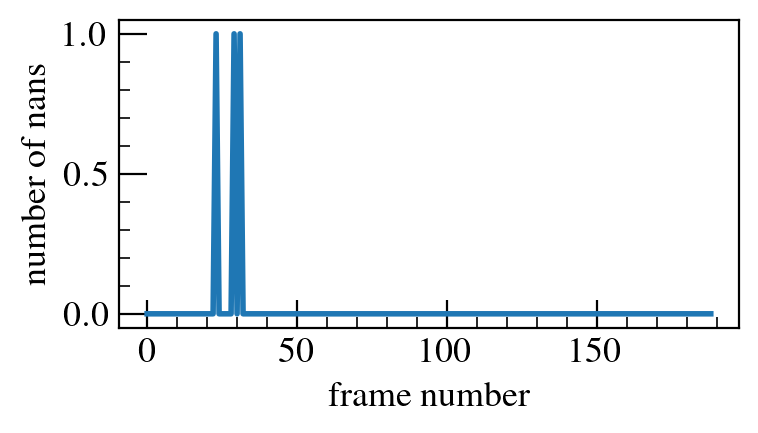

In [31]:
# convert ratios to concentration values
for i, num in enumerate(frame_num):
    #all averaged
    ratio_conc = ATP_inten_to_conc(output_ratios[i]['avg_ls'], Km, Rmax, Rmin, nhill)
    #each wedge
    ratio_bin_conc = ATP_inten_to_conc(output_ratios[i]['avg_bin_mat'], Km, Rmax, Rmin, nhill)
    #append conc units to dataframe
    output_ratios[i]['avg_ls_conc_units'] = ratio_conc
    output_ratios[i]['avg_bin_mat_conc_units'] = ratio_bin_conc
#--------------------------------------------------------------------#
#Plot the nans to see the distribution. If there are most nans at the end, 
#then it should be ok to set them to zero - likely the ratio is lower than 
#the calibration curve

numnan = []
for t in range(len(output_ratios)):
    num = np.sum(np.isnan(output_ratios[t]['avg_ls_conc_units']))
    numnan.append(num)

fig, ax = plt.subplots(figsize = (4,2))
ax.plot(np.arange(len(numnan)), numnan);
plt.ylabel('number of nans')
plt.xlabel('frame number')


#----------------#
#Set nans to zero
for t in range(len(output_ratios)):
    output_ratios[t]['avg_ls_conc_units'][np.isnan(output_ratios[t]['avg_ls_conc_units'])]=0

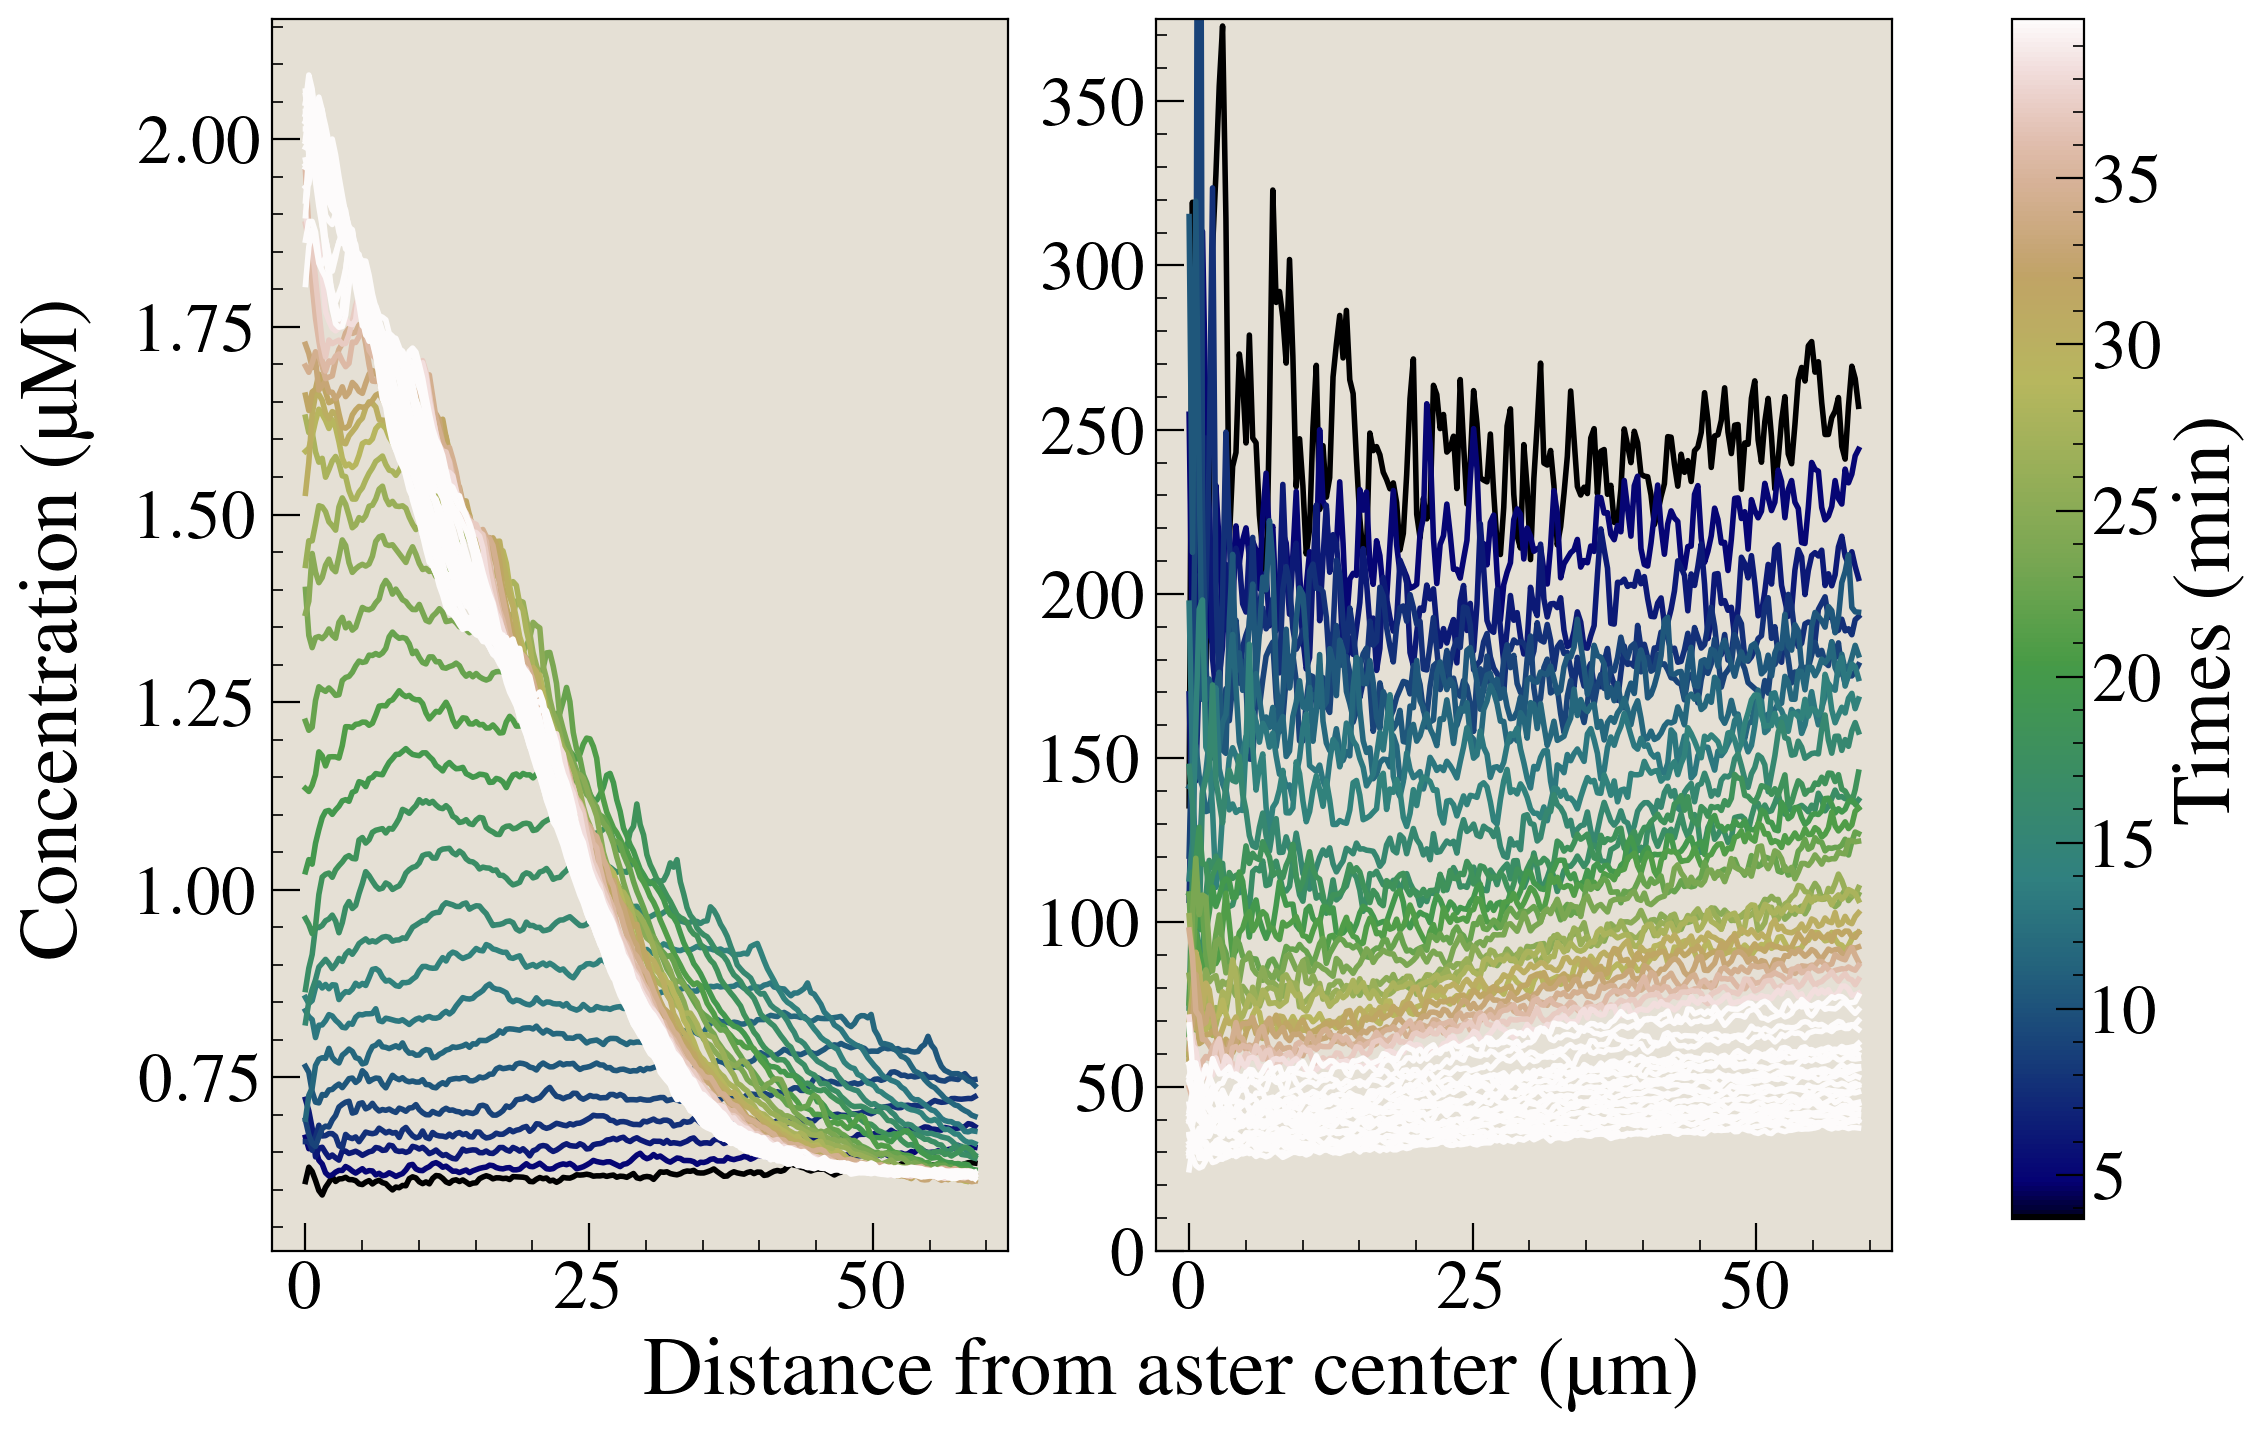

In [32]:
mod_num = 4

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_times.min(), vmax=0.6*plot_times.max())
colormap = cm.gist_earth
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(plot_times)

for i, frame in enumerate(plot_frames):
    if i%mod_num==0:
        ax[0].plot(output_mot[i]['r_unif_ls_um'],
                 output_mot[i]['avg_ls'],
                 lw=2,
                 color = colormap(normalize(plot_times[i])),
                 label=str(round(plot_times[i], 2)))

        ax[1].plot(output_ratios[i]['r_unif_ls_um'],
                 output_ratios[i]['avg_ls_conc_units'],
                 lw=2,
                 color = colormap(normalize(plot_times[i])),
                 label=str(round(plot_times[i], 2)))

#ax[0].set_box_aspect(1.5)
#ax[1].set_box_aspect(1.5)

fig.supxlabel('Distance from aster center (µm)', fontsize=30)
fig.supylabel('Concentration (µM)', fontsize=30)
# ax[0].set_ylabel('Motor Concentration (µM)')
# ax[1].set_ylabel('ATP Concentration (µM)')
# ax[0].set_xlabel('Distance from aster center (µm)')
# ax[1].set_xlabel('Distance from aster center (µm)')

ax[0].set_facecolor(color_background)
ax[1].set_facecolor(color_background)

ax[0].tick_params('both', labelsize=25)
ax[1].tick_params('both', labelsize=25)
ax[1].set_ylim(0, 375)

fig.subplots_adjust(right=0.8)
color_bar_ax = fig.add_axes([0.85, 0.13, 0.03, 0.75])
cbar = fig.colorbar(scalarmappable, cax=color_bar_ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label(label="Times (min)", size=30, weight='bold')

# scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappable.set_array(plot_times)
# cbar = plt.colorbar(scalarmappable, label = "Times (min)")

#fig.savefig('../../figures/Motor_ATP_Traces')

## Smooth Noise with a floating average
Define a function that averages over an interval for each point and replaces the point with the average. This reduces the noise of fluctuations

In [33]:
def float_avg(array, window):
    """ 
    Smooths noisy data by replacing individual values with the average of neighboring values
    
    Params:
    array: array of data to smooth
    window: half the interval (how many points to each side) you want to average over. - note this function does something strange 
    at the end where the last point takes the interval before and averages forgetting the interval after.So if your window is 1, 
    you average over 3 points, i-1, i, i+1. For the last point in the array, you only average two i-1, and i. I don't understand 
    why it isn't throwing an error but I am going with it. Note, I am keeping the first window value of points equal to their original 
    value without averageing. So in this case i=0 stays its original value and we start averaging when i=1
    
    Returns:
    Smoothed array witht he same length as the inputted array
    
    """
    smoo_array = []
    for i in range(len(array)):
        if i<window:
            smoo_array.append(array[i])
        else:
            smoo_array.append(np.average(array[i-window:i+window+1]))
    smoo_array = np.array(smoo_array)
    return smoo_array

Apply the function

In [34]:
for t in tqdm(range(len(plot_times))):
    output_ratios[t]['avg_ls_cu_smoo'] = float_avg(output_ratios[t]['avg_ls_conc_units'], 4)
    output_mot[t]['avg_ls_cu_smoo'] = float_avg(output_mot[t]['avg_ls'], 2)

  0%|          | 0/189 [00:00<?, ?it/s]

plot the result

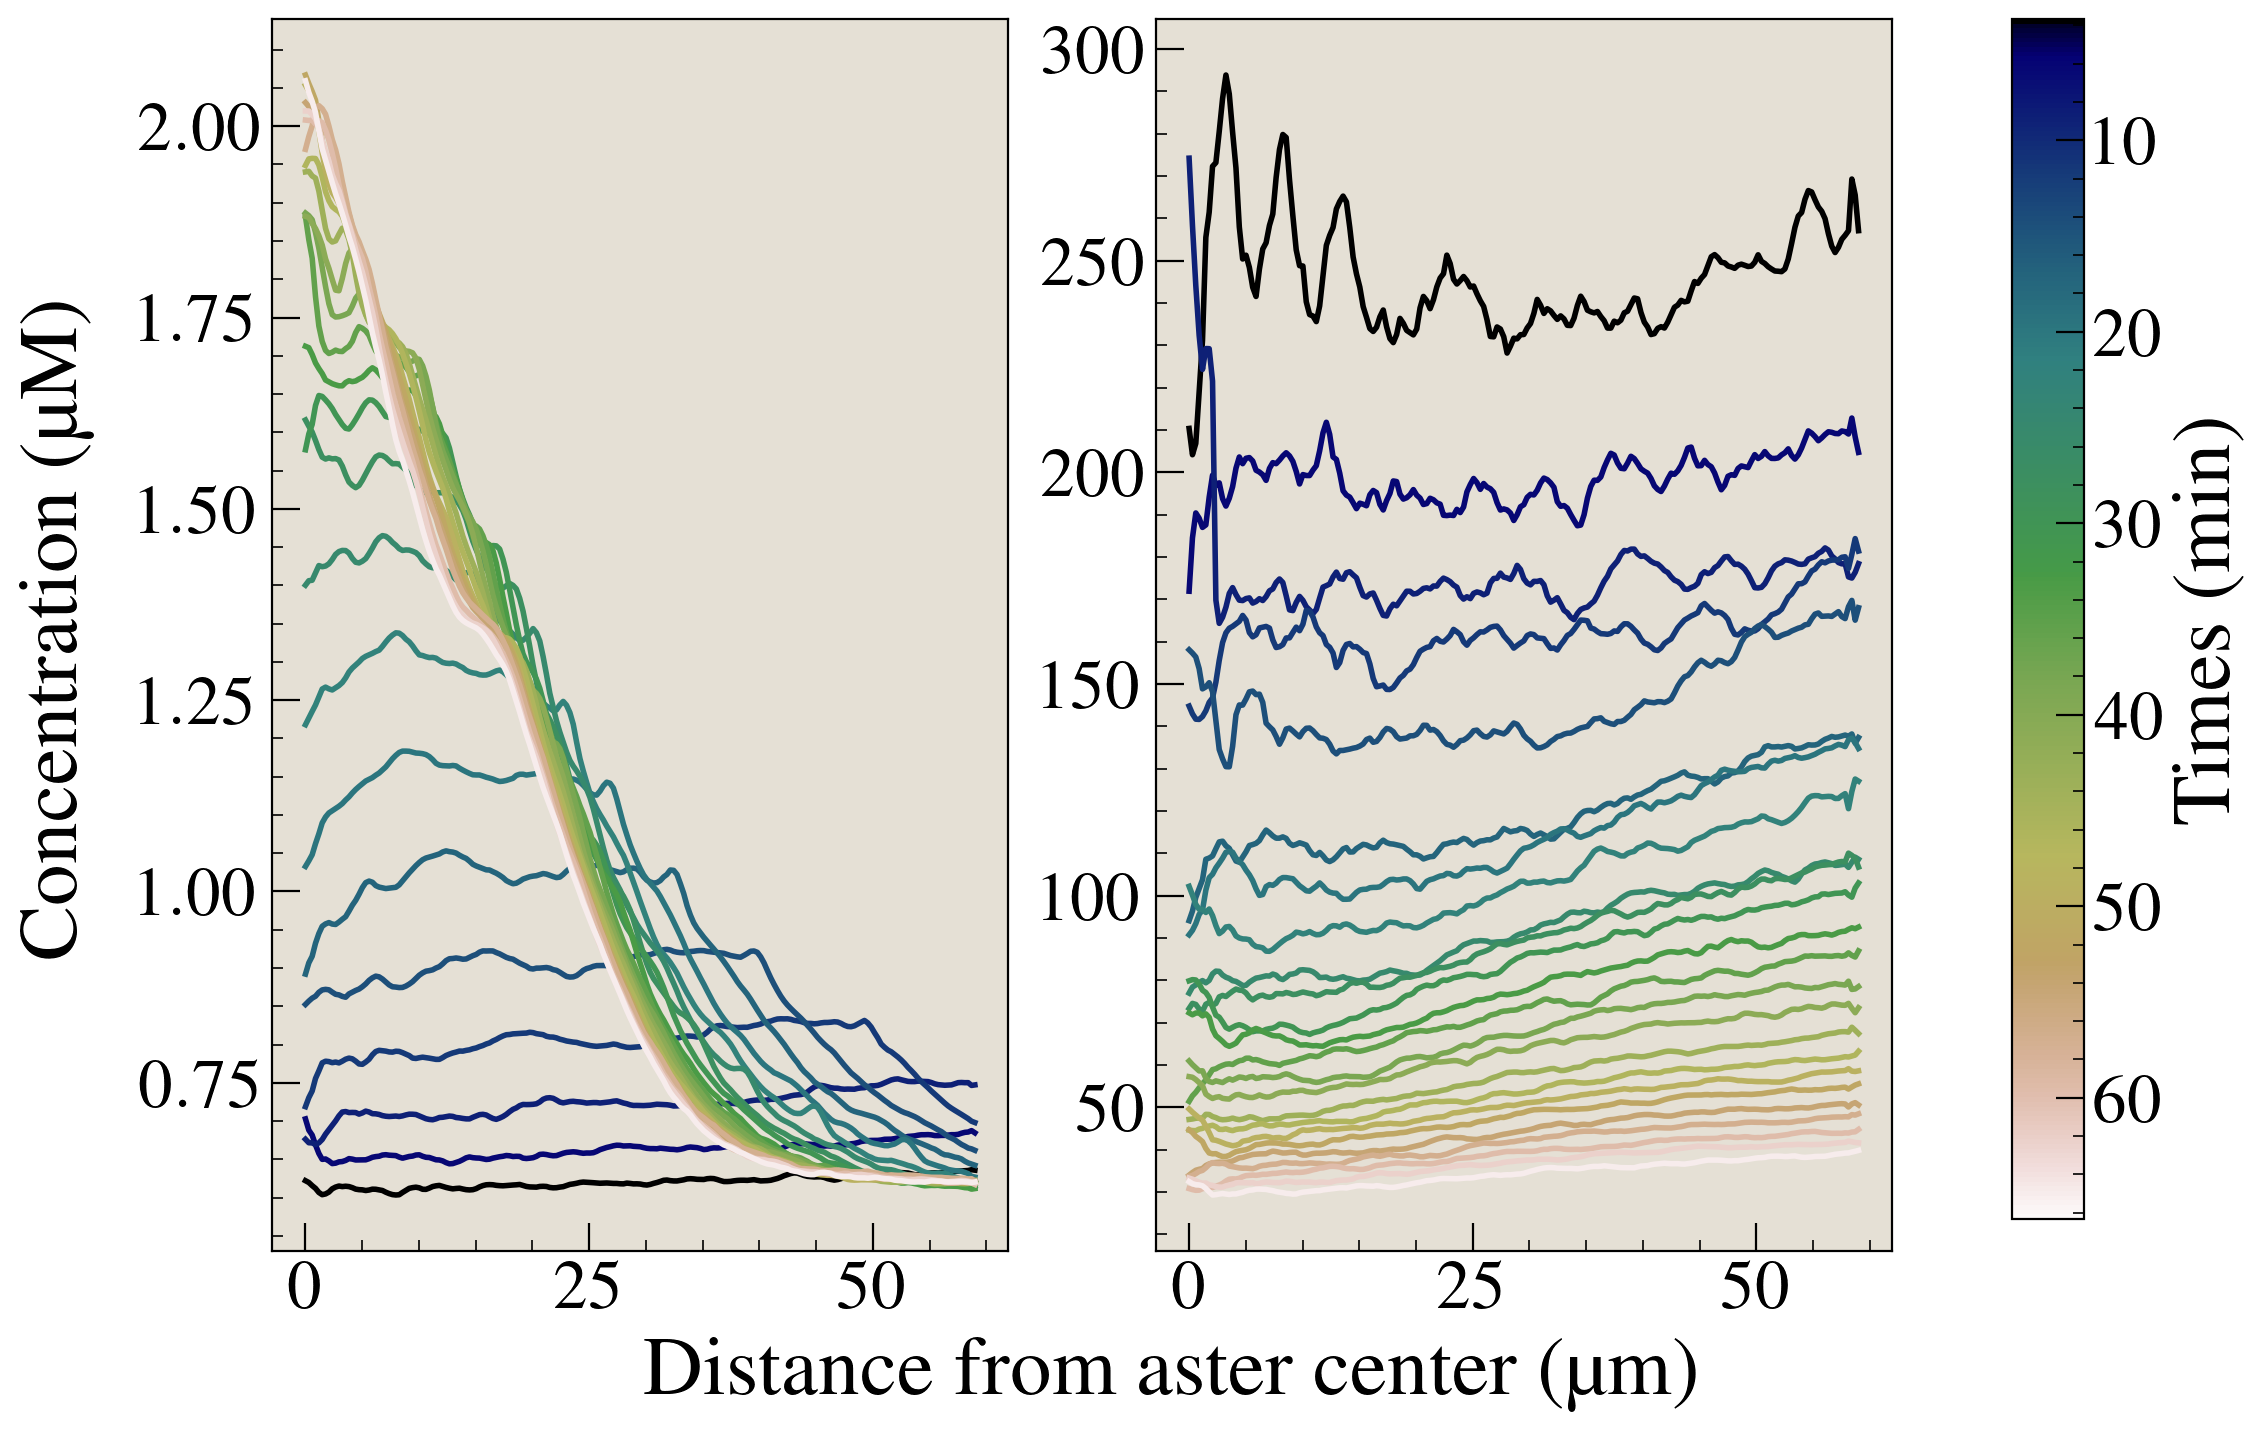

In [35]:
mod_num = 8

fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# setup the normalization and the colormap
normalize = mcolors.Normalize(vmin=plot_times.min(), vmax=plot_times.max())
colormap = cm.gist_earth
scalarmappable = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappable.set_array(plot_times)

for i, frame in enumerate(plot_frames):
    if i%mod_num==0:
        ax[0].plot(output_mot[i]['r_unif_ls_um'],
                 output_mot[i]['avg_ls_cu_smoo'],
                 lw=2,
                 color = colormap(normalize(plot_times[i])),
                 label=str(round(plot_times[i], 2)))

        ax[1].plot(output_ratios[i]['r_unif_ls_um'],
                 output_ratios[i]['avg_ls_cu_smoo'],
                 lw=2,
                 color = colormap(normalize(plot_times[i])),
                 label=str(round(plot_times[i], 2)))


fig.supxlabel('Distance from aster center (µm)', fontsize=30)
fig.supylabel('Concentration (µM)', fontsize=30)


ax[0].set_facecolor(color_background)
ax[1].set_facecolor(color_background)

ax[0].tick_params('both', labelsize=25)
ax[1].tick_params('both', labelsize=25)

fig.subplots_adjust(right=0.8)
color_bar_ax = fig.add_axes([0.85, 0.13, 0.03, 0.75])
cbar = fig.colorbar(scalarmappable, cax=color_bar_ax,)
cbar.ax.invert_yaxis()
cbar.ax.tick_params(labelsize=25)
cbar.set_label(label="Times (min)", size=30, weight='bold')
# ax[0].text(-14,6, '(A)', fontsize=30)
# ax[0].text(64 ,6, '(B)', fontsize=30)

#fig.savefig('../../analyzed_data/aster/2022-06-28_NCD_ATeam_UMT/2022-06-28_NCD_ATeam_UMT_R4_1/Motor_ATP_Traces(lessLines).pdf', dpi=400, transparent=True)

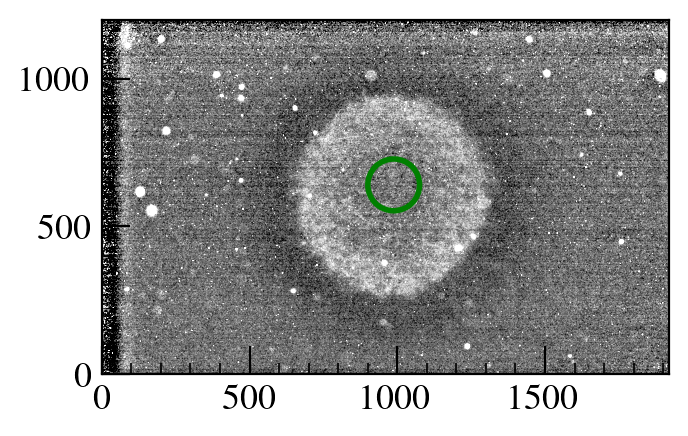

In [36]:
demiindex = 8
fig, ax = plt.subplots()
im = im_arraymot_bs_norm_bleach[demiindex]
#im = ims_mot_conc[demiindex]
ax.imshow(im, 
           origin='lower', 
#            extent = (-r_outer, r_outer, -r_outer, r_outer),
           vmin = np.percentile(im, 10), vmax = np.percentile(im, 97),#vmax_default),
           cmap = "Greys_r")
ax.add_patch(patches.Circle((centers[demiindex][0], centers[demiindex][1]), radius=radii_um[frame_num][demiindex], color = 'g', linewidth=2, fill=False))
#ax.add_patch(patches.Circle((winsize-0.5, winsize-0.5), radius=radii_um[frame_num][demiindex], color = 'g', linewidth=2, fill=False))

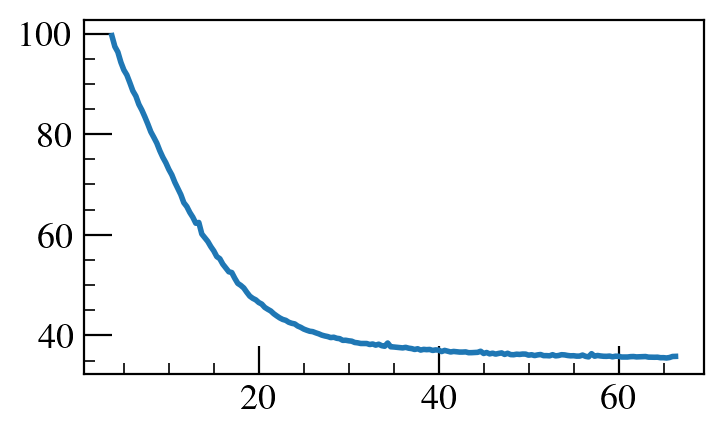

In [37]:
plt.plot(plot_times, radii_um[frame_num])

# Power
We need to normalize any power measurements by the area over which the ATP concentrations are measured. Because we take radial averages over various radii, the corresponding area for each measurement increases with the radius. Say we take $m$ measurements with a radius interval of $\Delta r$. Then the area over which we measure for a given radius $r$ goes as,

$$A = \pi \left(r+ \frac{\Delta r}{2} \right)^2 - \pi \left(r- \frac{\Delta r}{2} \right)^2$$
$$= \pi \left( r^2 + r\Delta r + \frac{(\Delta r)^2}{4} - r^2 + r\Delta r - \frac{(\Delta r)^2}{4}\right)$$
$$= 2\pi r\Delta r $$


We convert this to a volume by multiplying the area by the depth of the flow cell, assuming this is the depth we image over.

First lets find the $\Delta r$ and $\Delta t$ values

In [38]:
deltat = round((plot_times[1]-plot_times[0])*60) # seconds
deltar = output_ratios[0]['r_unif_ls_um'][1] - output_ratios[0]['r_unif_ls_um'][2] #um
N_A = scipy.constants.Avogadro
depth = 70 #um

print('delta t: ' + str(deltat))
print('delta r: ' + str(round(deltar,2)))

delta t: 20
delta r: 0.3


In [39]:
toroid_area = []
for r, radius in enumerate(tqdm(output_ratios[0]['r_unif_ls_um'])):
    area = 2*np.pi*radius*deltar #(r + deltar/2)^2 - (r - deltar/2)^2 = r^2 + rdeltar + deltar^2/4 - r^2 + rdeltar - deltar^2/4
    toroid_area.append(area)
toroid_area = np.array(toroid_area) #um^2
toroid_vol = toroid_area*depth #um^3
toroid_vol_m3 = toroid_vol*1e-18

  0%|          | 0/201 [00:00<?, ?it/s]

## Define power function

In [40]:
def power_prof(times, conc_trace, toroid_vol_m3, rbound, deltat):
    power=[]
    for i, frame in enumerate(times[:-1]):
        #subtract the traces in the region
        pow_uM_per_s =-(conc_trace[i+1]['avg_ls_cu_smoo'][rbound[0]:rbound[1]] 
                         - conc_trace[i]['avg_ls_cu_smoo'][rbound[0]:rbound[1]])/deltat
        pow_umol_per_s = np.sum(pow_uM_per_s*toroid_vol_m3[rbound[0]:rbound[1]]*1000) #*1000 bc 1000L/m^3
        pow_ATP_per_s = pow_umol_per_s*1e-6*N_A
        power.append(pow_ATP_per_s)
    return np.array(power)

## Compute power!

In [41]:
ratios_power = power_prof(plot_frames, output_ratios, toroid_vol_m3, [0,200], deltat)

94089336816.99384

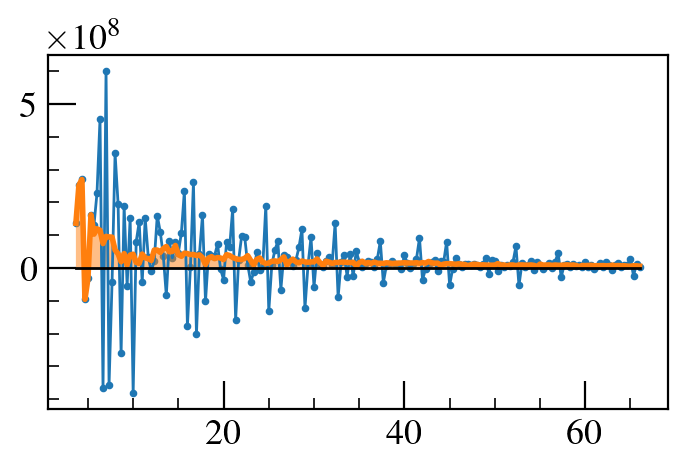

In [42]:
plt.scatter(plot_times[:-1],
            ratios_power,
            s=3)
plt.plot(plot_times[:-1],
         ratios_power,
         lw=1,)
ratios_power_smoo = float_avg(ratios_power,6)
plt.plot(plot_times[:-1],
         ratios_power_smoo,
         lw=2,)
plt.fill_between(plot_times[:-1],
         ratios_power_smoo,
         alpha = 0.5)
plt.plot(plot_times[:-1],
         np.zeros(len(plot_times[:-1])),
         lw=1,
        color='k')
np.sum(ratios_power_smoo[:180])*deltat
#          color = colormap(normalize(i)),
#          label=str(round(plot_times[i], 2)))
#plt.ylim(-1, 2)

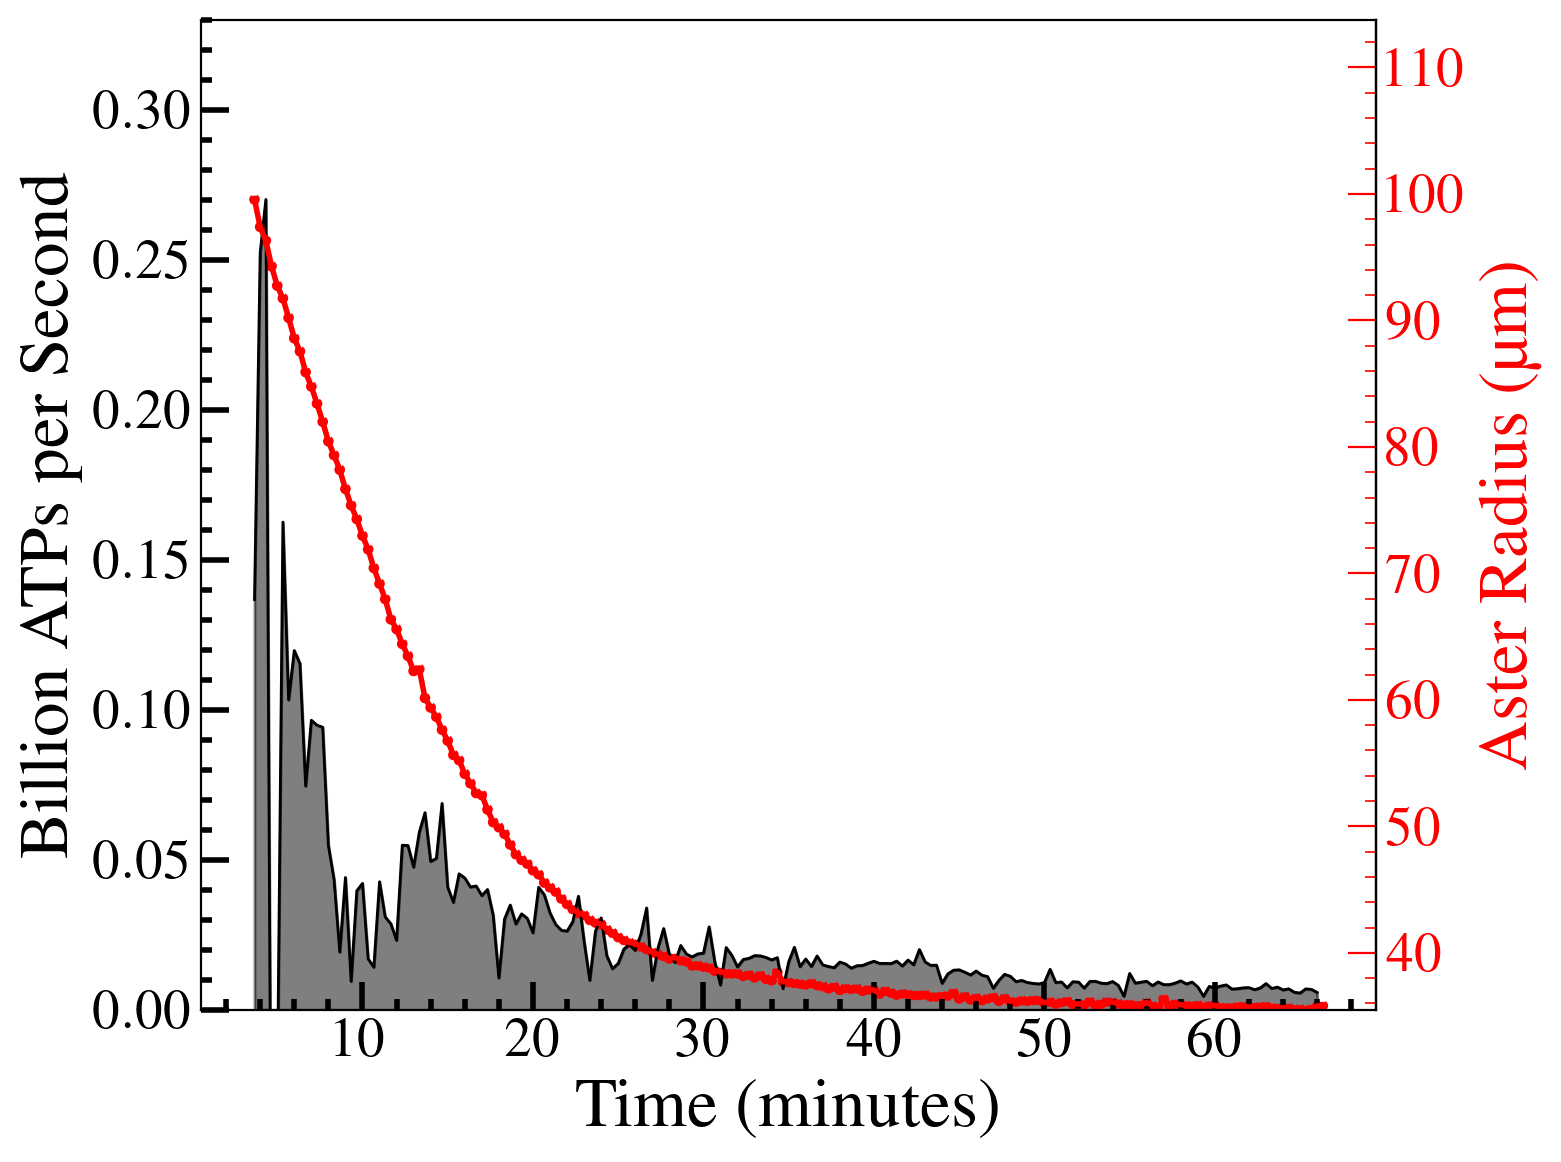

In [43]:
max_pow_val = np.max(ratios_power_smoo)/1e9 #in um a
max_arad_val = np.max(radii_um[frame_num]) #in um c
min_arad_val = np.min(radii_um[frame_num]) #in um b
def Pow2R(x):
    return (max_arad_val - min_arad_val)* x / max_pow_val + min_arad_val
def R2Pow(y):
    return (y - min_arad_val) * max_pow_val/ (max_arad_val - min_arad_val)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(plot_times[:-1],
         ratios_power_smoo/1000000000,
         lw=1,
        label = 'Power',
        color = 'k')#'#76B4A6')
ax.fill_between(plot_times[:-1],
     ratios_power_smoo/1000000000,
     alpha = 0.5,
     color = 'k')#'#6CA58F')
ax.plot(plot_times,
         R2Pow(radii_um[frame_num]),
         lw=2,
        linestyle='-',
        label = 'Aster Radius',
        color = 'r',)#'#76B4A6')
ax.scatter(plot_times,
         R2Pow(radii_um[frame_num]),
         s=8,
        linestyle='--',
        color = 'r',)
ax.tick_params('both', labelsize = 20)
# ax.set_title('Power', fontsize = 50)
ax.set_ylabel('Billion ATPs per Second', fontsize=25)
ax.set_xlabel('Time (minutes)', fontsize = 25)
ax.tick_params('both', which = 'both', width=2)
ax.set_ylim(0, 0.33)
secax_y = ax.secondary_yaxis('right', functions=(Pow2R, R2Pow))
secax_y.set_ylabel('Aster Radius (µm)', fontsize = 25, color = 'r')
secax_y.tick_params('both', labelsize = 20, which = 'both', color = 'r', labelcolor='r')

#plt.xlim(-2, 70)
#plt.legend()
plt.tight_layout()
#fig.savefig('../../analyzed_data/aster/2022-06-28_NCD_ATeam_UMT/2022-06-28_NCD_ATeam_UMT_R4_1/totPow&Radius.pdf', dpi=400)